In [18]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
sys.path.append('../../pytools')
import d2l

d2l.gpu_mem_init()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [19]:
batch_size = 256
mi_train,mi_test = d2l.load_data_fashion_mnist(batch_size)

In [20]:
num_inputs = 784
num_outputs = 10
w = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs), mean=0.0, stddev=0.01))
b = tf.Variable(tf.zeros(shape=(num_outputs)))

In [21]:
def softmax(x):
    x_exp = tf.exp(x)
    partiton = tf.reduce_sum(x_exp, axis=1, keepdims=True)
    return x_exp/partiton

In [22]:
def net(x):
    return softmax(tf.matmul(tf.reshape(x, (-1, w.shape[0])), w) + b)

In [23]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(y_hat, tf.one_hot(y, depth=(y_hat.shape[-1]))))

In [24]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, dtype=y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

In [25]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [26]:
def evaluate_accuracy(net, data_iter):
    metric = Accumulator(2)
    for x,y in data_iter:
        metric.add(accuracy(net(x), y), len(y))
    return metric[0] / metric[1]

evaluate_accuracy(net, mi_test)

0.0533

In [27]:
evaluate_accuracy(net, mi_test)

0.0533

In [28]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras内置的损失接受的是（标签，预测），这不同于用户在本书中的实现。
            # 本书的实现接受（预测，标签），例如我们上面实现的“交叉熵”
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras的loss默认返回一个批量的平均损失
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [29]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        train_loss, train_acc = train_metrics
        animator.add(epoch + 1, train_metrics + (test_acc,))
        print(f'epoch:{epoch}, train_loss:{train_loss:f}, train_auc:{train_acc:f}')
    return net

In [30]:
class Updater():  #@save
    """用小批量随机梯度下降法更新参数"""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

updater = Updater([w, b], lr=0.08)

epoch:9, train_loss:0.455966, train_auc:0.846900


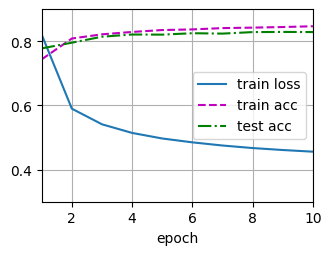

In [31]:
num_epochs = 10
my_net = train_ch3(net, mi_train, mi_test, cross_entropy, num_epochs, updater)

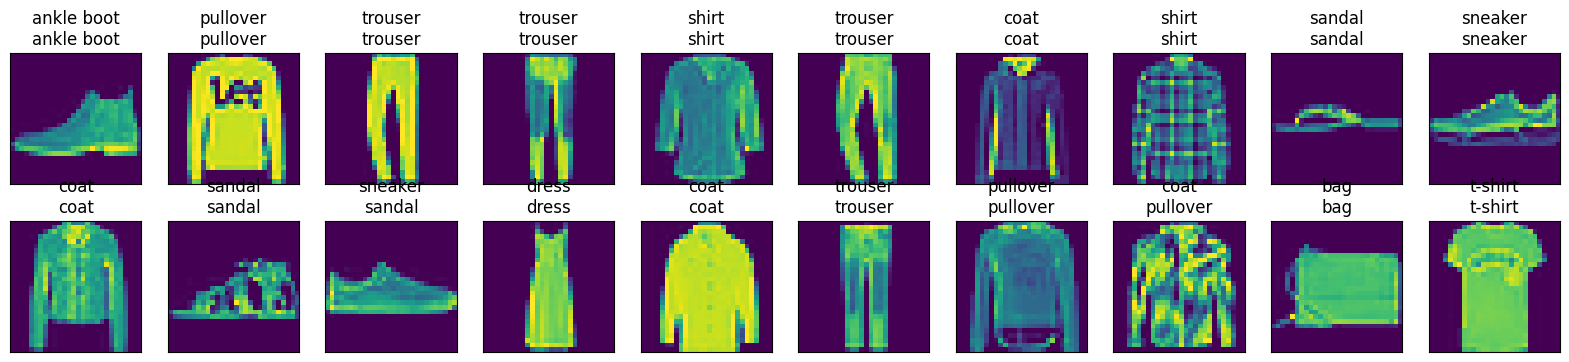

In [32]:
def predict_ch3(net, mi_test, n = 20):
    for x,y in mi_test:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(tf.argmax(net(x), axis=1))
    titles = [true + '\n' + pred for true,pred in zip(trues, preds)]
    d2l.show_images(tf.reshape(x[0:n], (n, 28, 28)), 2, 10, titles[0:n])
predict_ch3(net, mi_test)